# Effect of wrong measurements

If the data association fails the nextStep model receives an improbable measurement.
This notebook explores what happens when a rnn track with a "solid state" receives such measurements (for example when an identity switch occurs).

"solid state" means, that the track receive many correct measurements before.

In [1]:
import logging
logging.getLogger('tensorflow').disabled = True

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print('Tensorflow version:', tf.__version__)
print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [10, 5]

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.1.0-rc1
GPU support: True


In [3]:
!wget -N pollithy.com/rnn_model_fake_data.h5

--2020-01-11 16:26:23--  http://pollithy.com/rnn_model_fake_data.h5
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/rnn_model_fake_data.h5 [following]
--2020-01-11 16:26:23--  https://pollithy.com/rnn_model_fake_data.h5
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34203912 (33M)
Saving to: ‘rnn_model_fake_data.h5’

rnn_model_fake_data 100%[===================>]  32.62M  11.0MB/s    in 3.0s    

2020-01-11 16:26:26 (11.0 MB/s) - ‘rnn_model_fake_data.h5’ saved [34203912/34203912]



In [4]:
# load model
model = tf.keras.models.load_model('rnn_model_fake_data.h5')

batch_size = 64

# summarize model.
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 28, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 28, 1024)            4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (64, 28, 16)              66624     
_________________________________________________________________
dense_7 (Dense)              (64, 28, 2)               34        
Total params: 4,273,250
Trainable params: 4,273,250
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'These are the measurements which we feed to all particles at a certain timestep.')

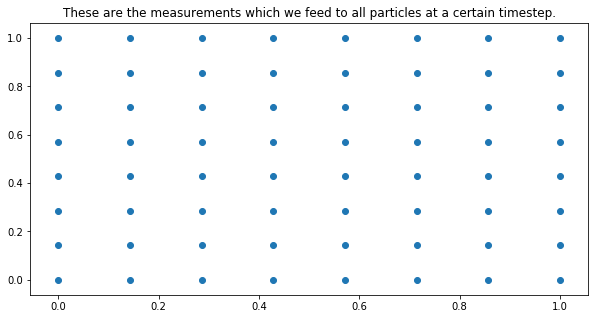

In [5]:
step_length = 1/7.

all_measurements = []

for x in range(8):
  for y in range(8):
    all_measurements.append([[x*step_length, y*step_length]])

all_measurements = np.array(all_measurements)
plt.scatter(all_measurements[:, :, 0], all_measurements[:, :, 1])
plt.title("These are the measurements which we feed to all particles at a certain timestep.")

0.0 0.0


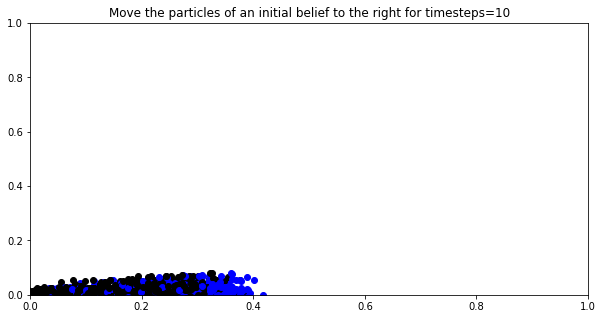

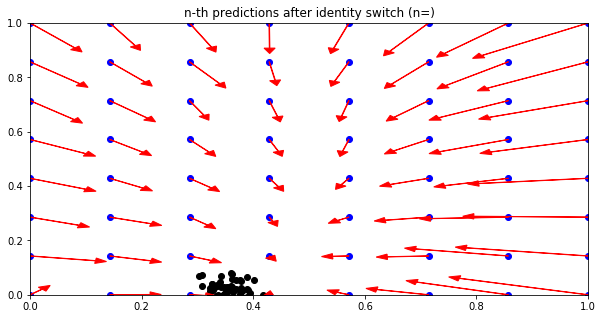

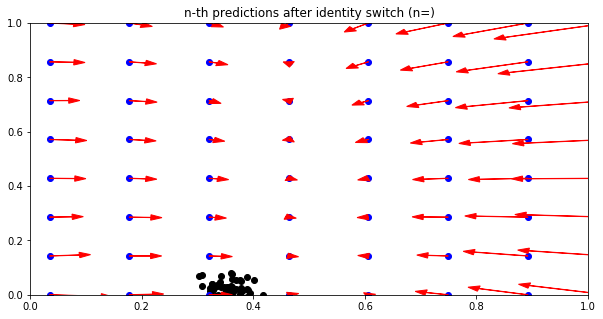

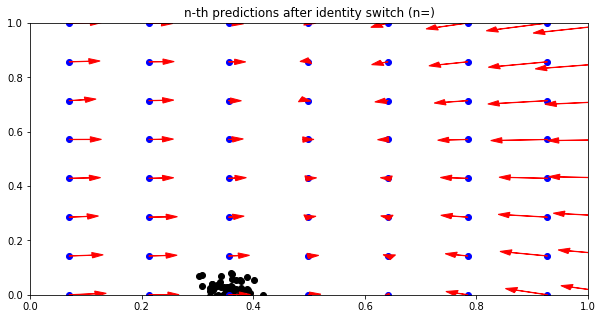

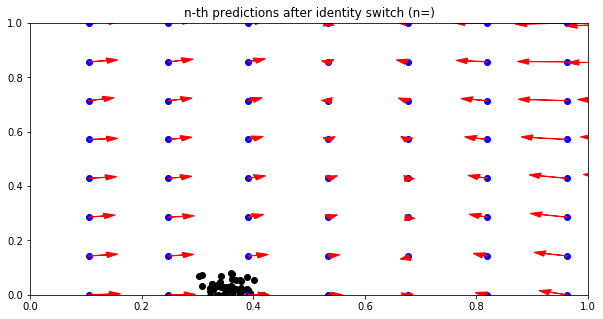

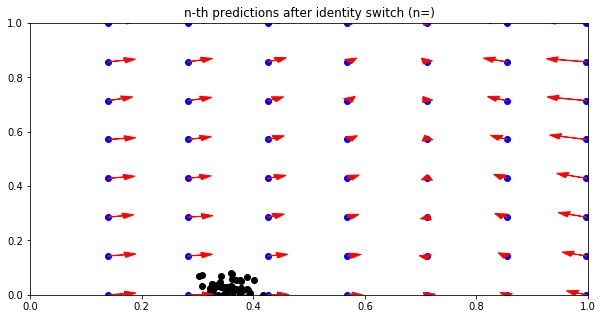

0.0 0.14285714285714285


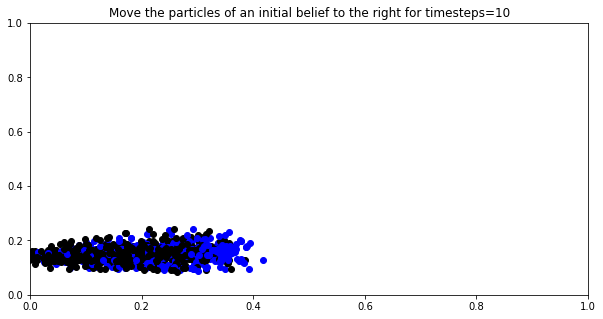

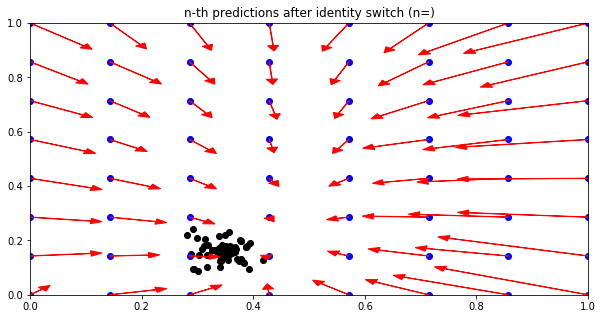

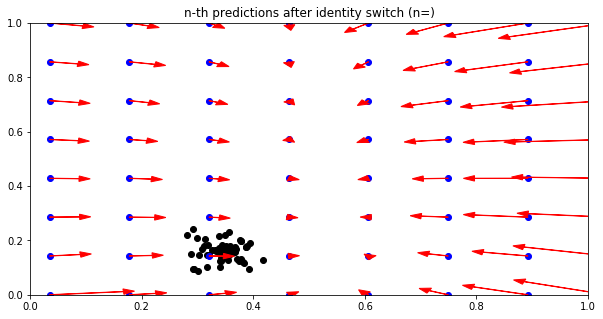

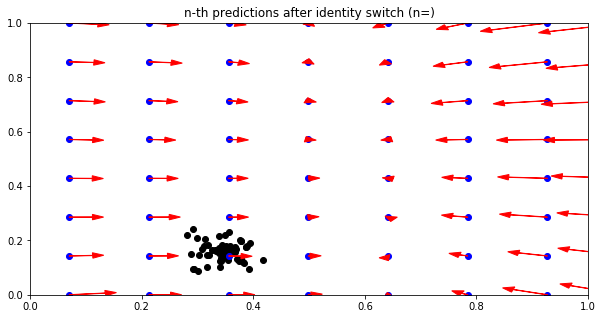

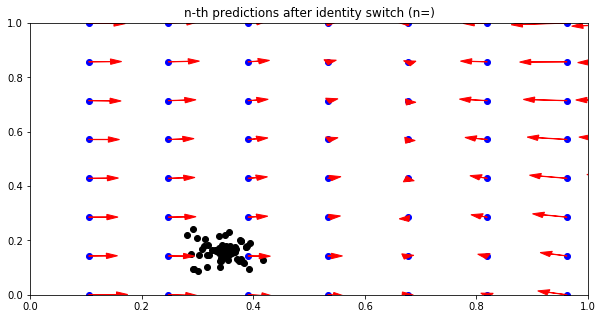

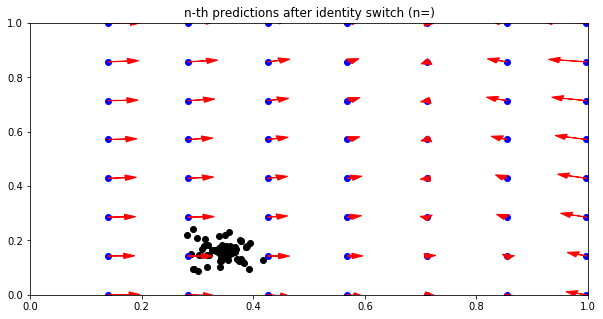

0.0 0.2857142857142857


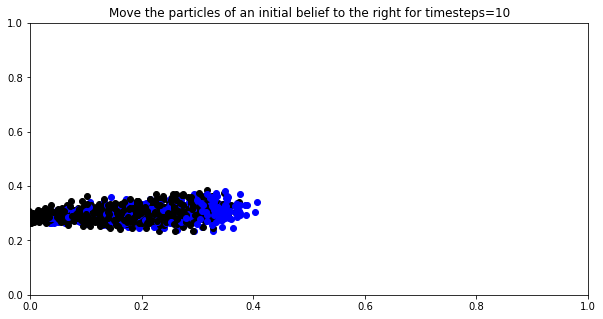

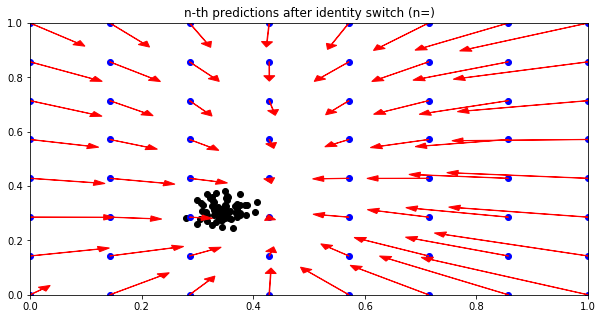

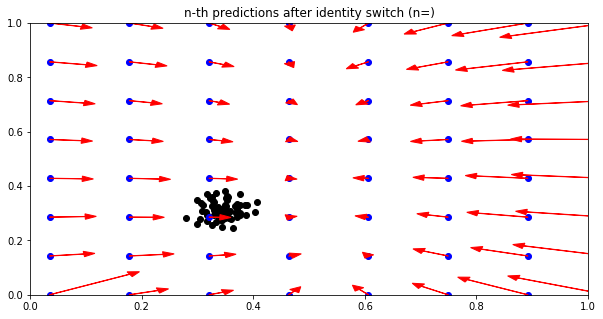

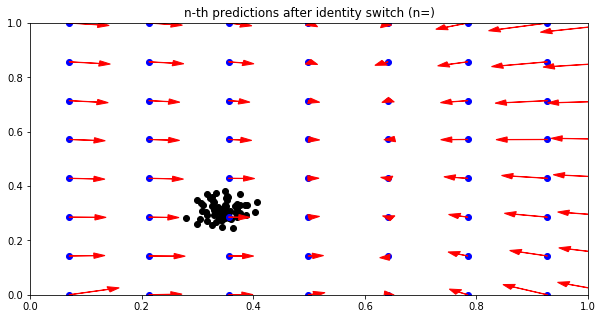

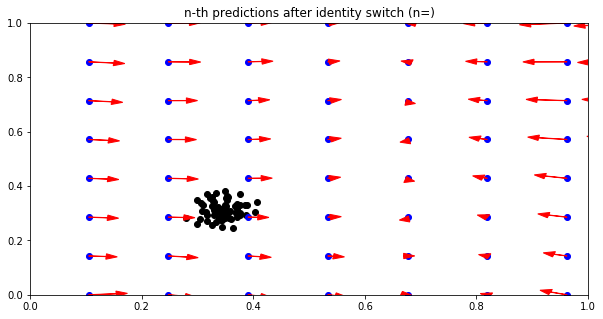

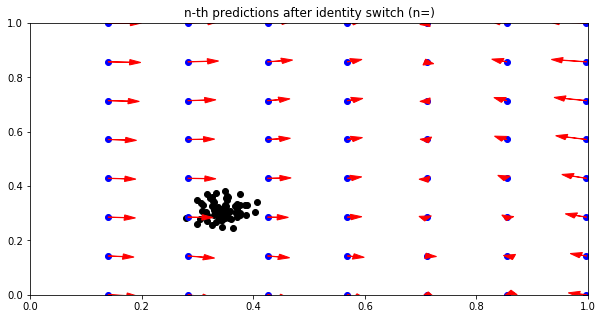

0.0 0.42857142857142855


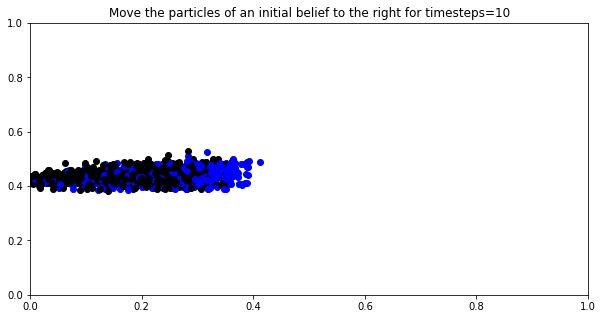

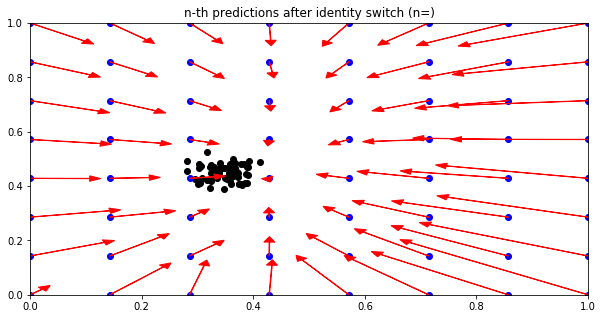

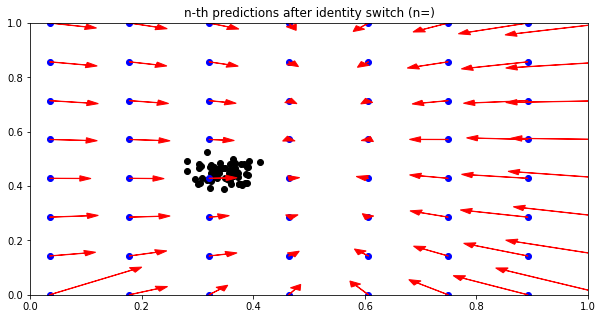

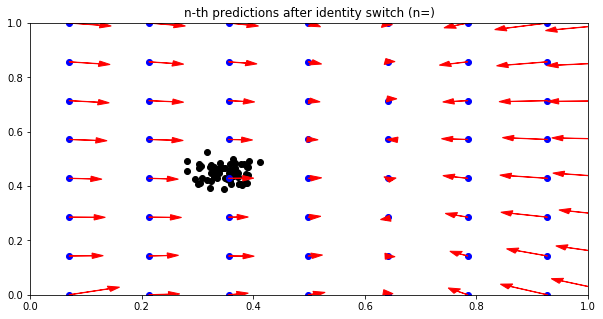

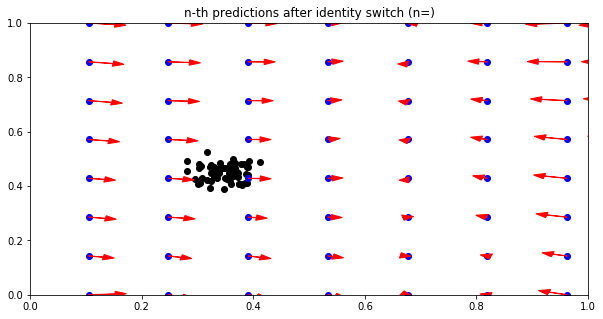

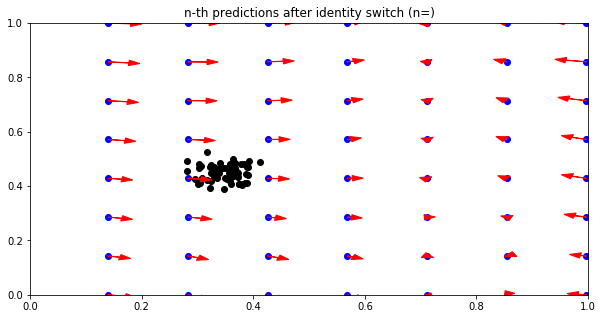

0.0 0.5714285714285714


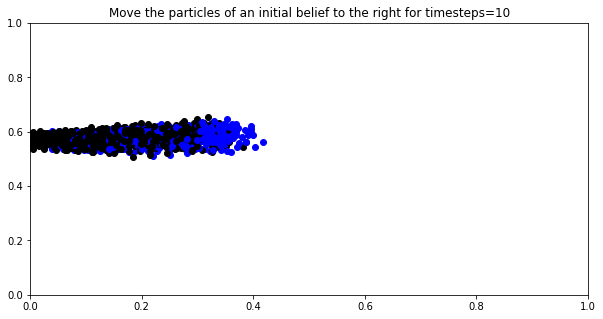

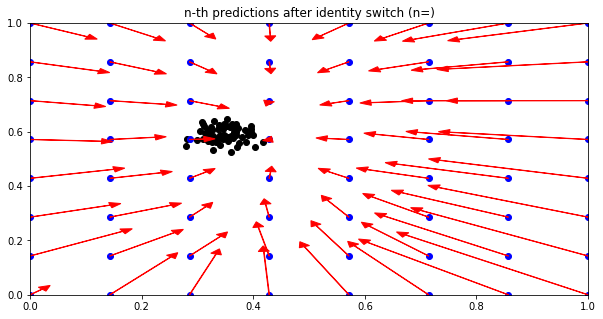

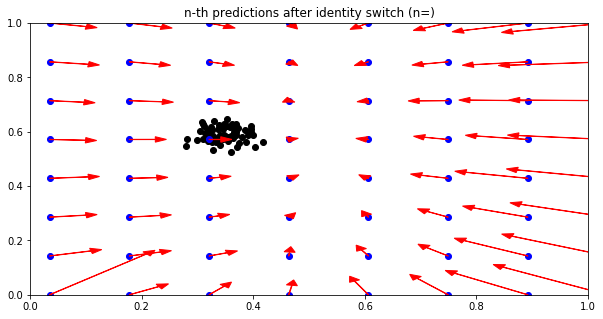

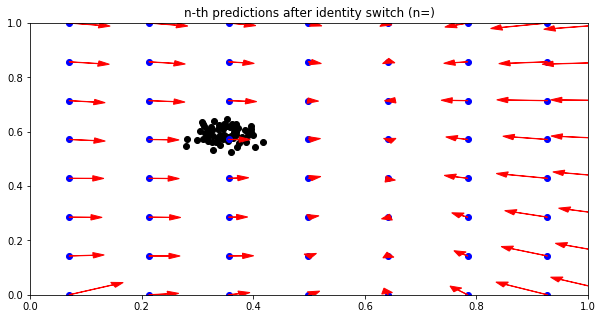

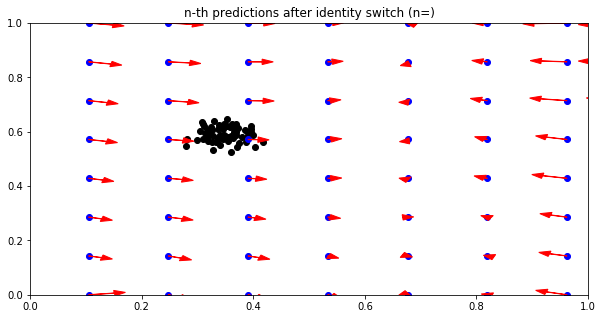

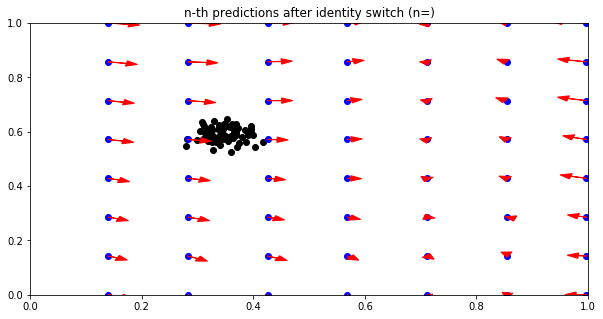

0.0 0.7142857142857142


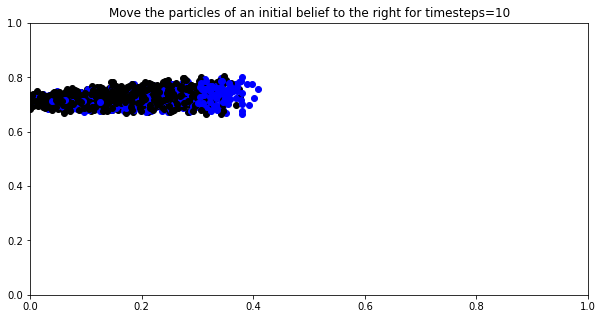

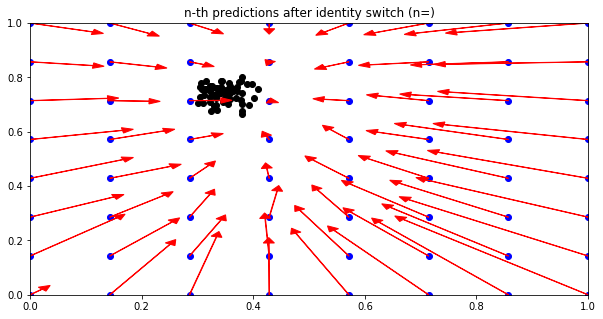

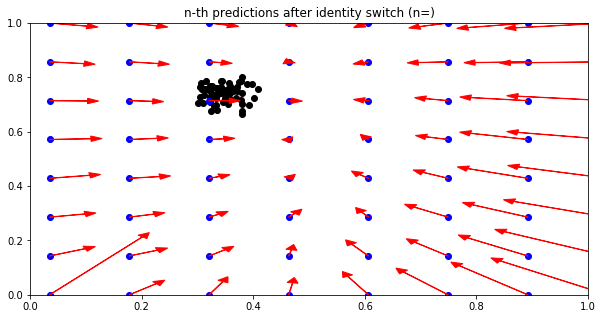

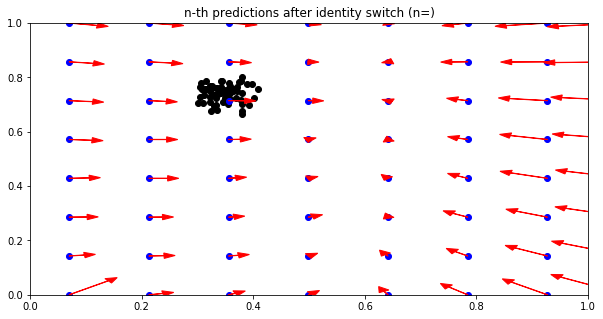

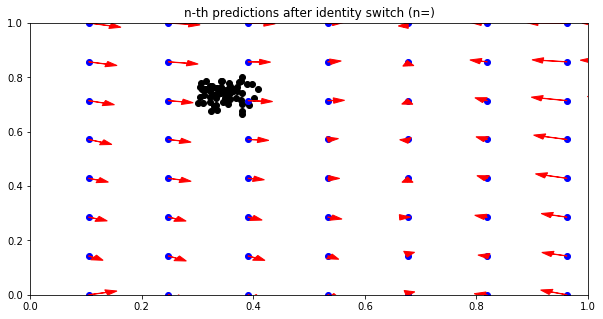

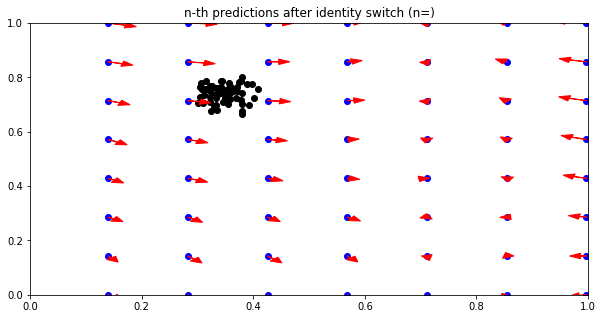

0.0 0.8571428571428571


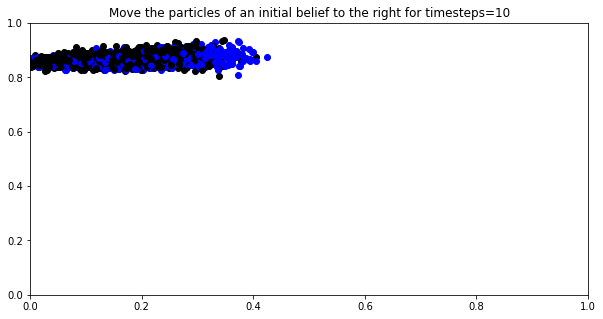

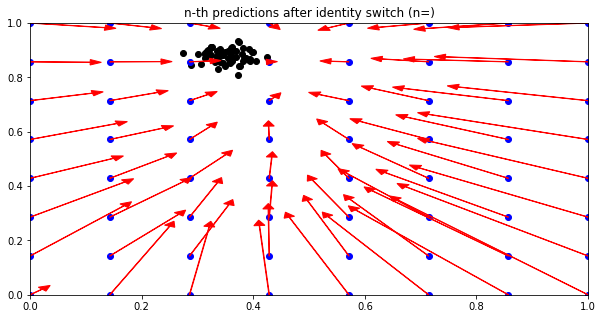

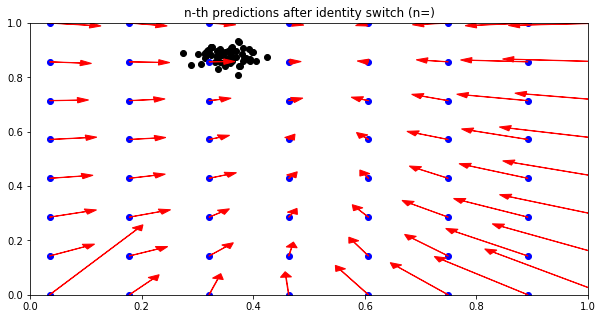

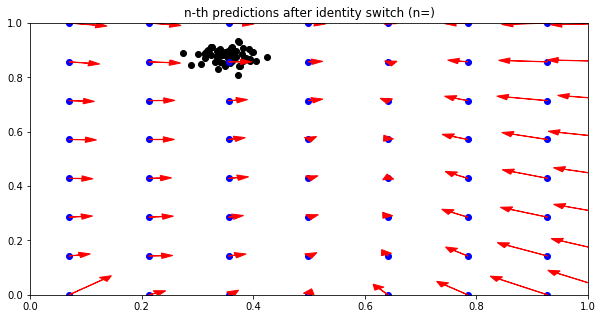

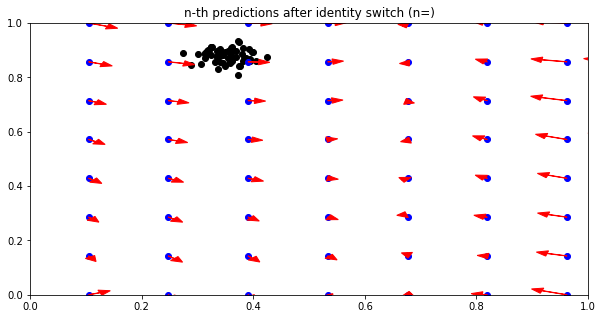

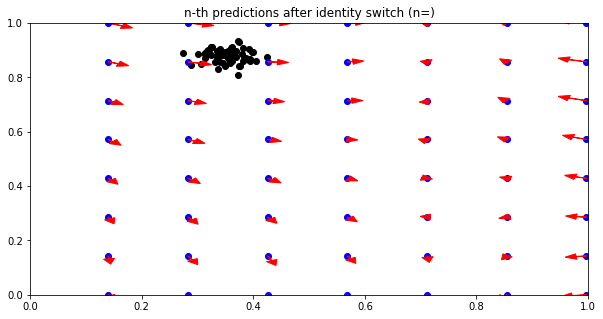

0.0 1.0


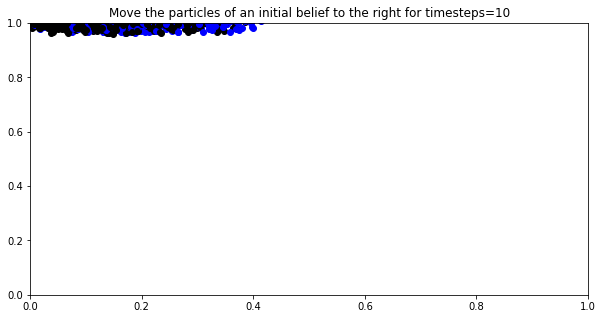

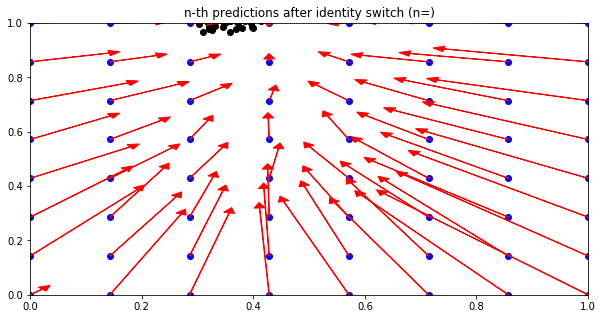

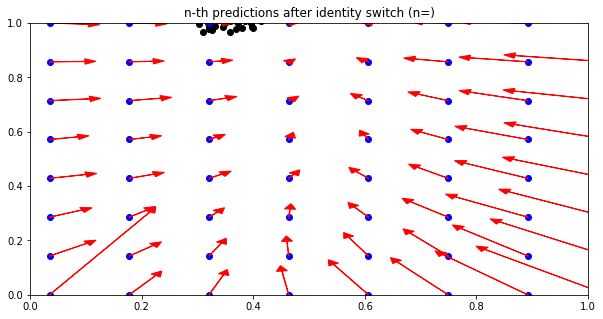

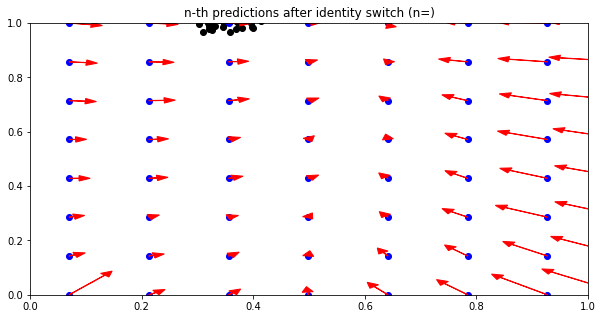

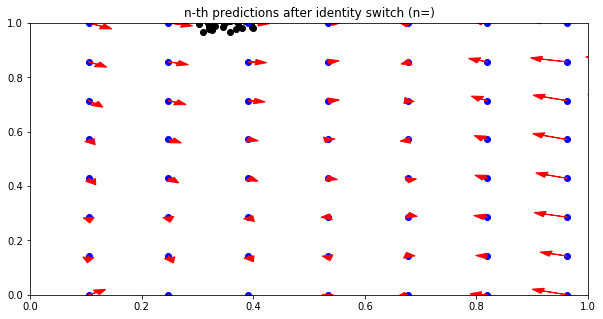

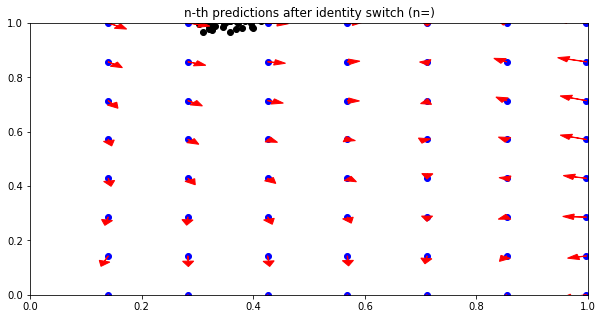

0.14285714285714285 0.0


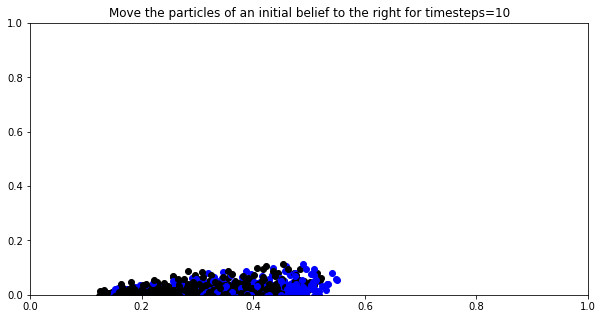

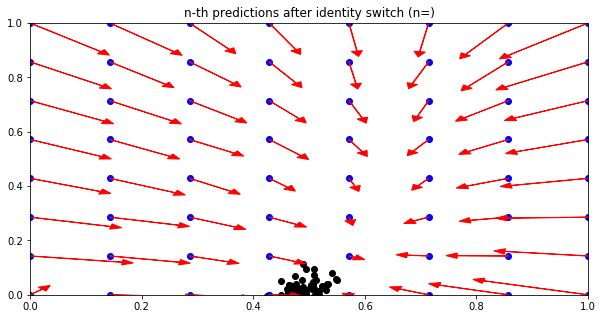

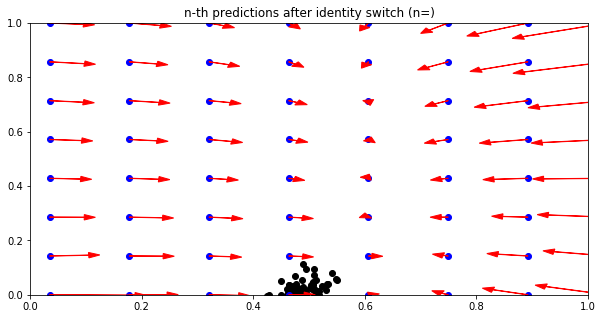

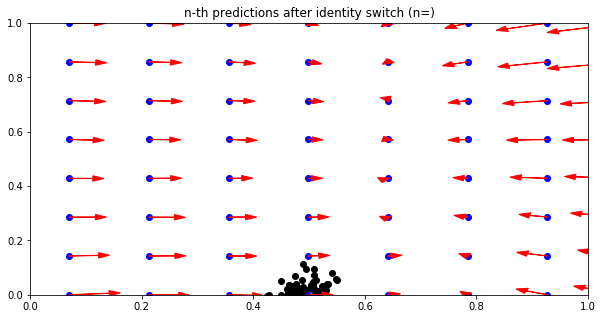

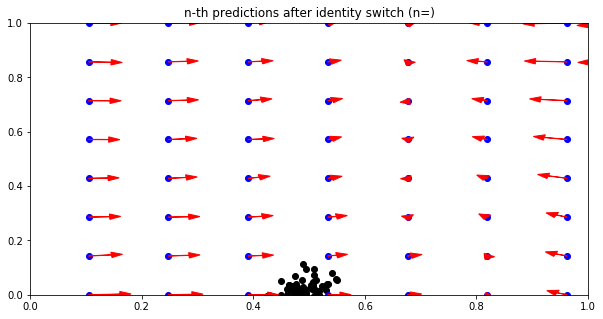

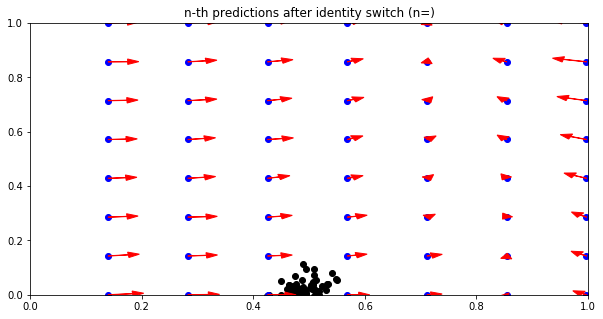

0.14285714285714285 0.14285714285714285


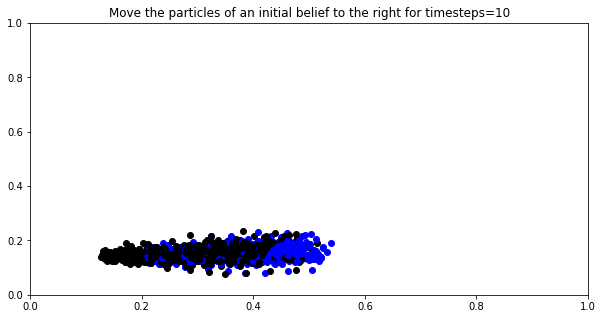

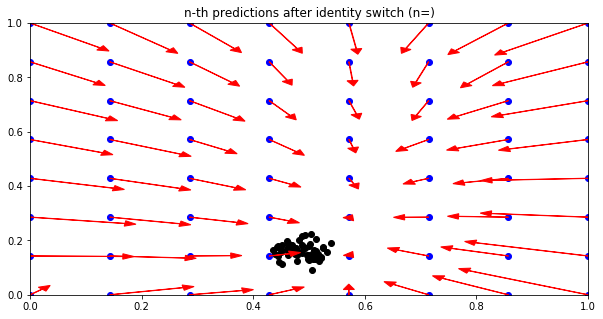

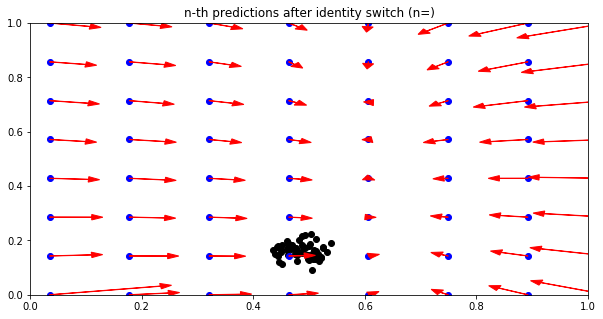

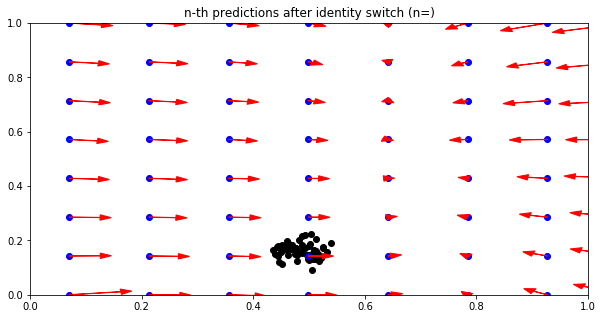

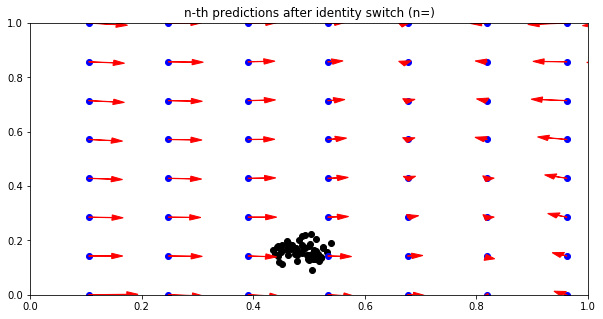

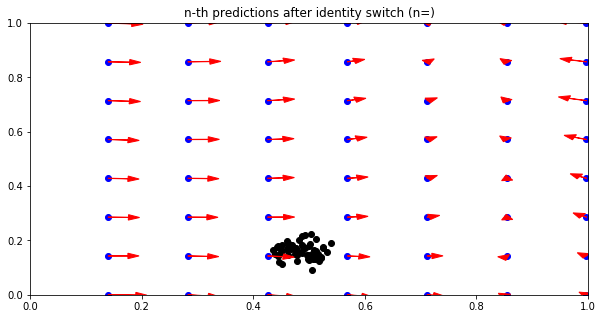

0.14285714285714285 0.2857142857142857


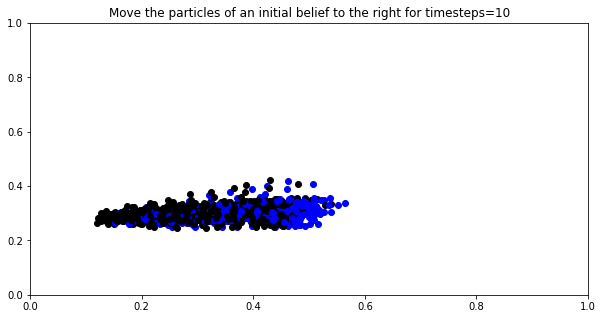

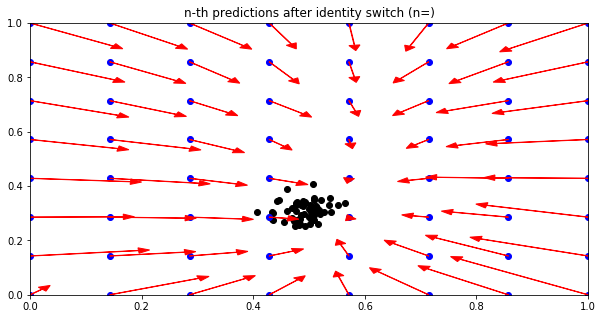

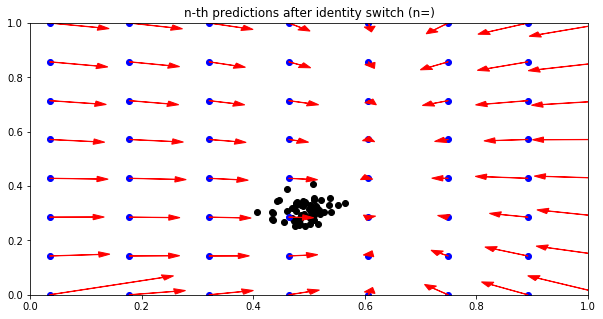

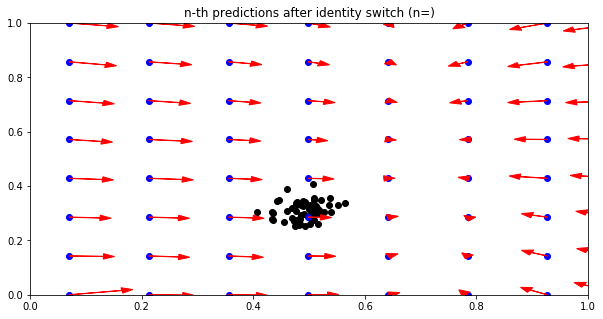

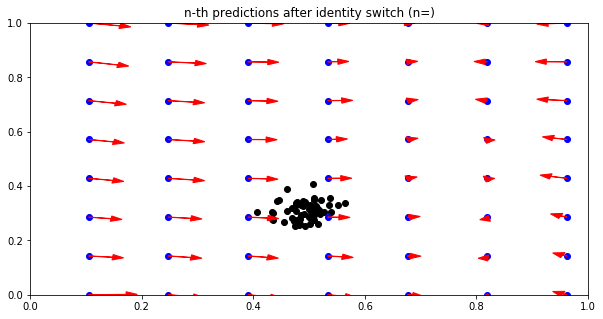

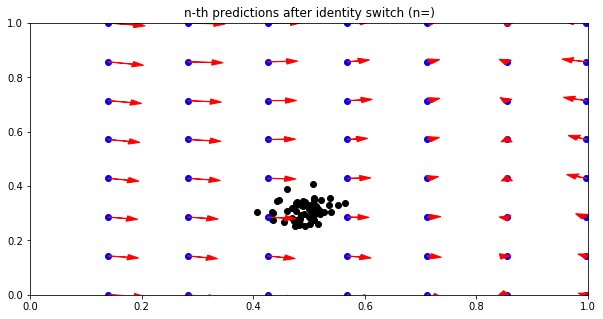

0.14285714285714285 0.42857142857142855


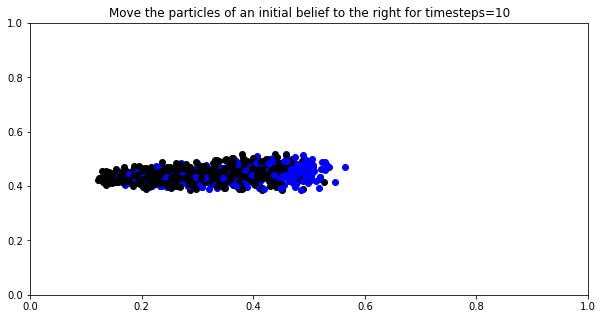

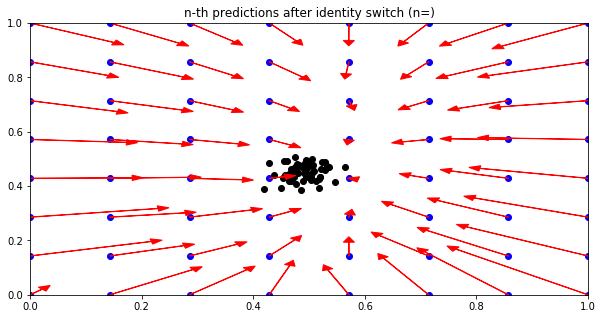

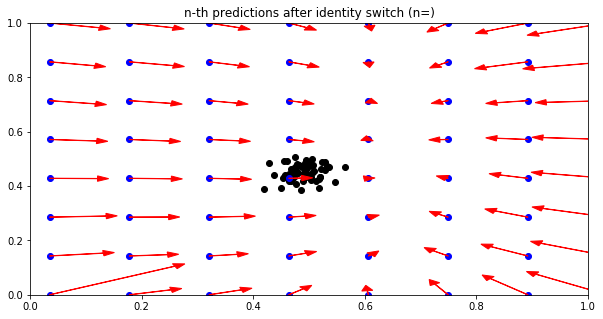

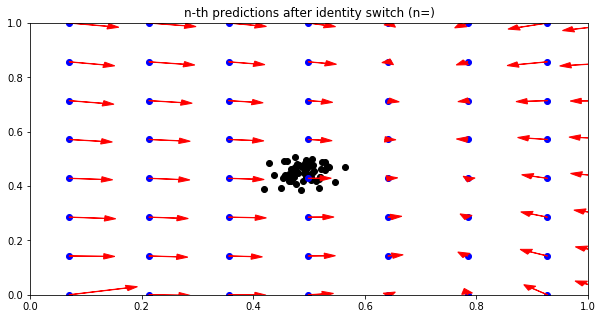

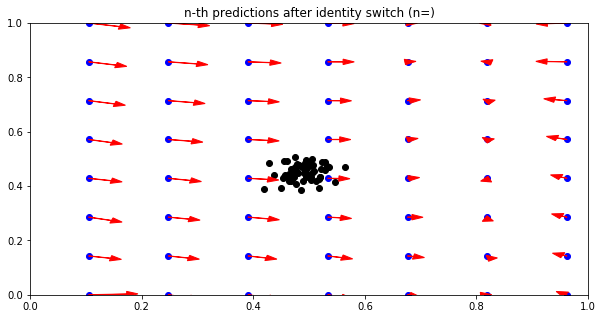

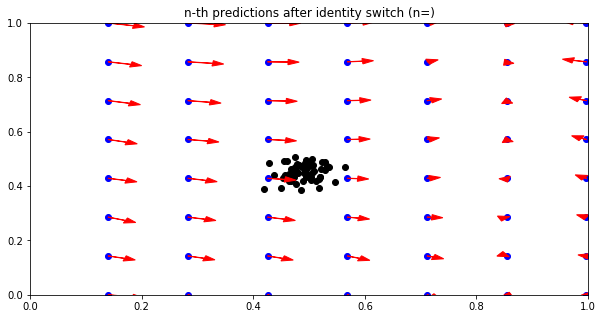

0.14285714285714285 0.5714285714285714


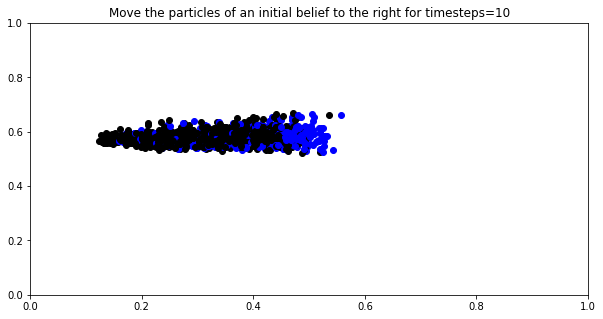

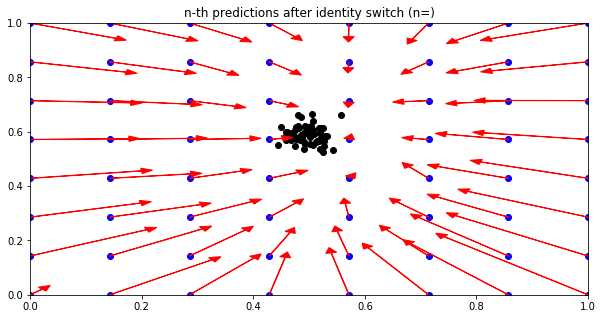

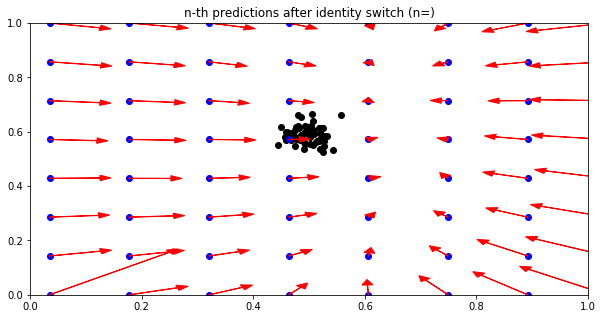

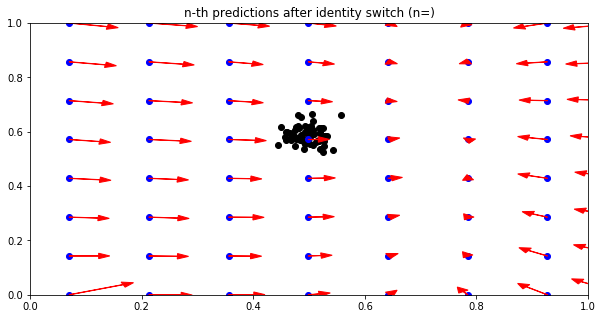

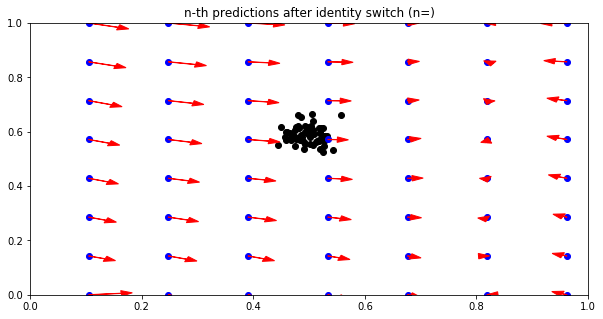

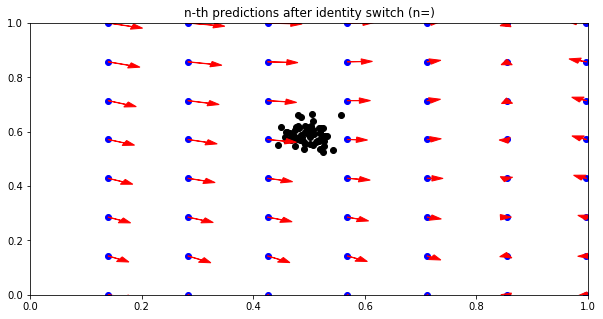

0.14285714285714285 0.7142857142857142


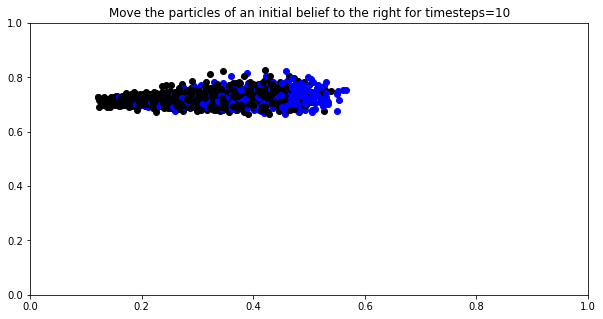

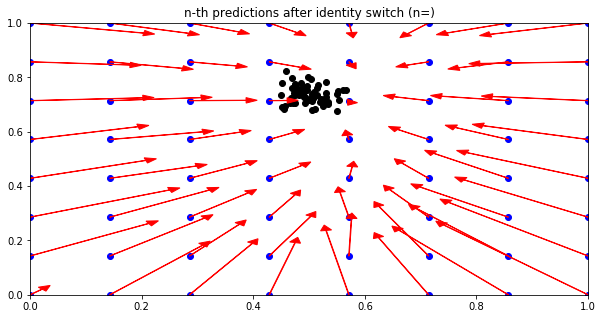

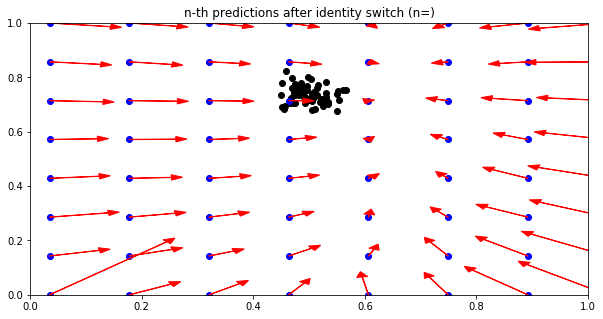

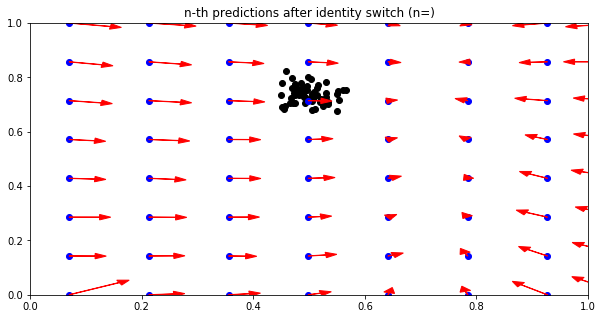

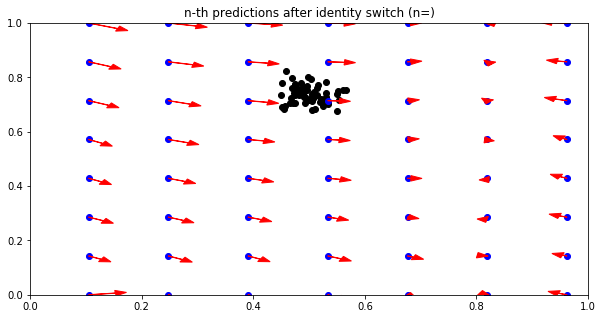

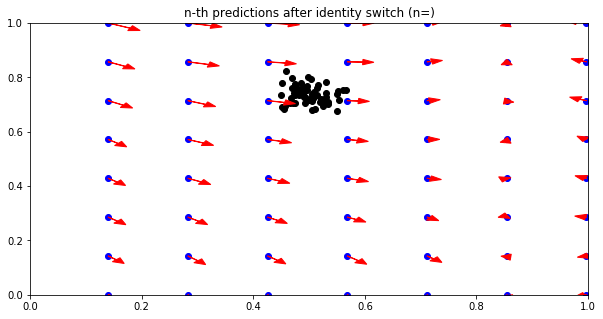

0.14285714285714285 0.8571428571428571


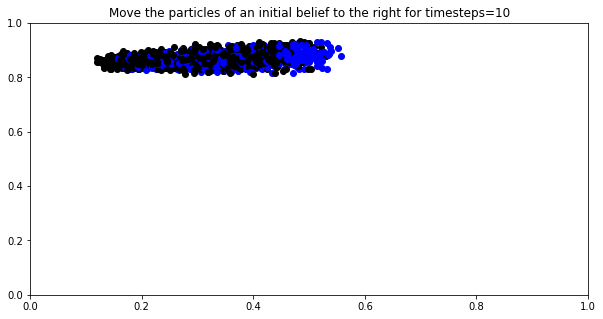

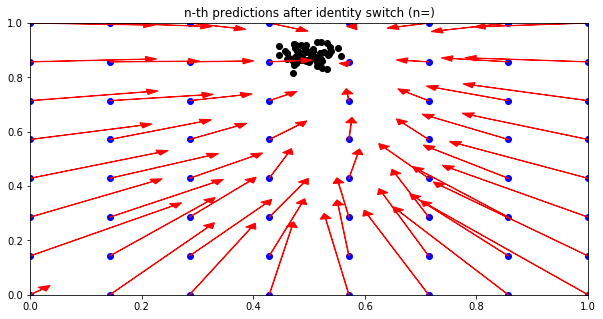

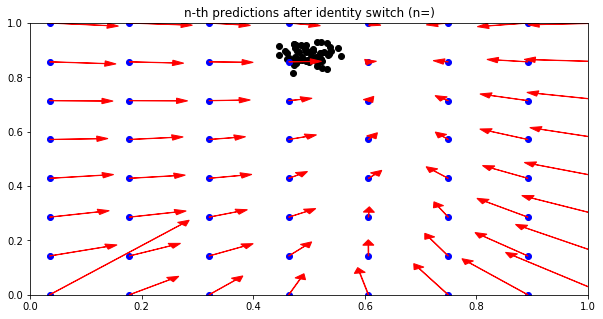

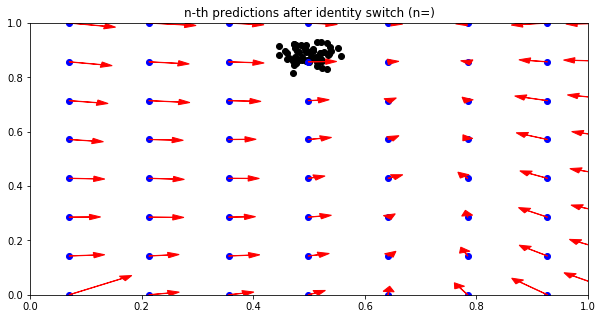

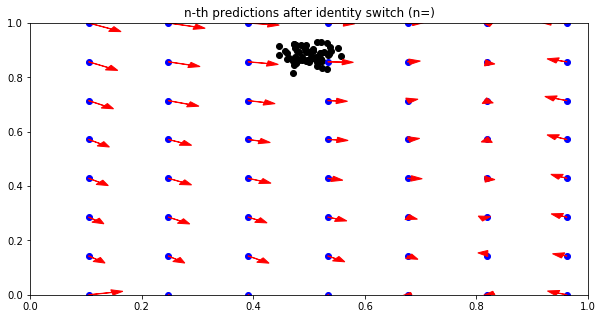

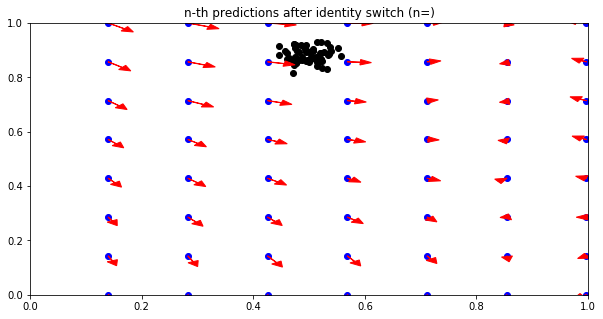

0.14285714285714285 1.0


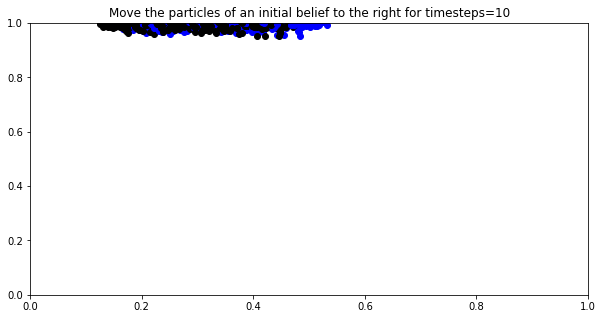

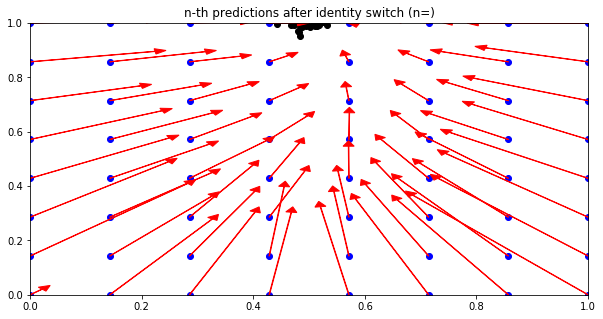

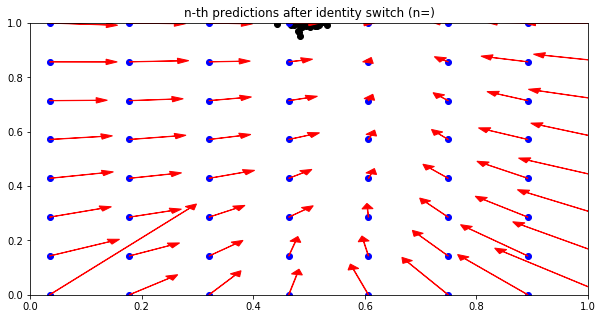

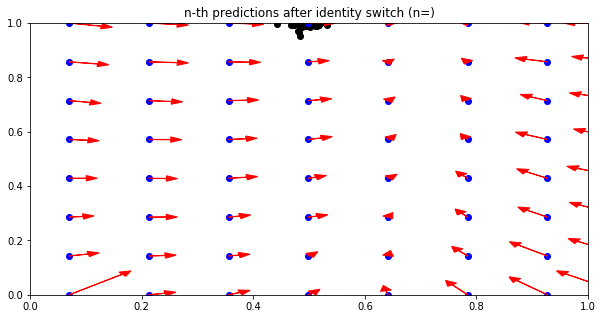

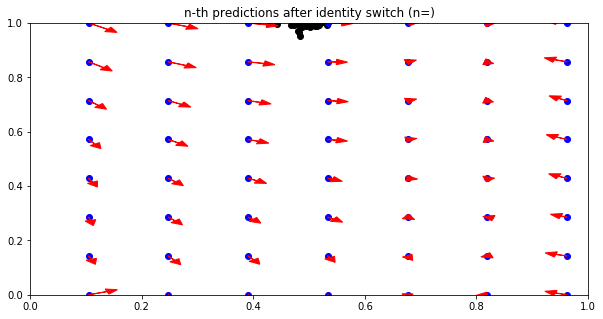

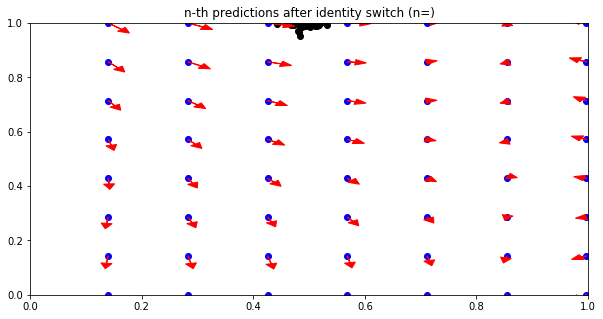

In [6]:
for x in range(2):
  for y in range(8):
    # ------------------------------
    # Init
    #-------------------------------
    x_pos = x * step_length
    y_pos = y * step_length

    print(x_pos, y_pos)
    
    batch = np.zeros(shape=[batch_size, 1, 2]) 
    batch[:, :, 0] = x_pos
    batch[:, :, 1] = y_pos

    batch += np.random.normal(loc=0, scale=0.01, size=[batch_size, 1, 2])

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # ------------------------------
    # Move
    # ------------------------------
    model.reset_states()
    num_t = 10
    for t in range(num_t):
      plt.scatter(batch[:, :, 0], batch[:, :, 1], color="black")
      preds = model(batch)
      plt.scatter(preds[:, :, 0], preds[:, :, 1], color="blue")
      
      batch[:, :, :] += np.random.normal(loc=[70/2000.,5/2000.], scale=[0.01, 0.01], size=[batch_size, 1, 2])

    plt.title("Move the particles of an initial belief to the right for timesteps={}".format(num_t))
    plt.show()

    # -------------------------------
    # Wrong measurements
    # -------------------------------

    wrong_measurements = all_measurements.copy()

    for w_i in range(5):
      plt.scatter(preds[:, :, 0], preds[:, :, 1], color="black")
      plt.scatter(wrong_measurements[:, :, 0], wrong_measurements[:, :, 1], color="blue")

      new_preds = model(wrong_measurements).numpy()

      plt.xlim([0, 1])
      plt.ylim([0, 1])

      for i in range(batch_size):
        meas = wrong_measurements[i, 0, :]
        pred = new_preds[i, 0, :]
        from_ = meas # x,y
        delta_ = pred-meas

        plt.arrow(from_[0], from_[1], delta_[0], delta_[1], color="red", 
                  length_includes_head=True, head_width=0.02, head_length=0.02)
      
      plt.title("n-th predictions after identity switch (n=)".format(w_i+1))
      plt.show()

      wrong_measurements[:, :, 0] += 70./2000.